Target :
 - Add Lr schuler - Step size 10 ( why 10 ? - bcoz we reached target accuracy at 9th/10th epoch, so we want it to consistent post that )


 Result:
- Params: 8066
- Train Accuracy: 99.6 (from 11th till 14th Epoch)
- Test Accuracy : 99.4 (from 9th and 14th Epoch )

Analysis:
- Still no overfitting
- Getting target accuracy consistently
- next try to reduce params below 8k

In [ ]:
import torch 
import torch.nn as nn
import torchvision
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

seed=121

torch.manual_seed(seed)

print("Using Cuda : ", use_cuda)


Using Cuda :  True


In [ ]:
#Get the MNIST dataset

train_dataset =  torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))


test_dataset =  torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#define Data loaders

Batch_size = 64

dataloader_args= dict(shuffle=True, batch_size=Batch_size,num_workers=4, pin_memory=True ) if use_cuda else dict(shuffle=True, batch_size=Batch_size)

train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)



In [ ]:
#data Statistics
train = train_dataset.train_data
train = train_dataset.transform(train.numpy())


print("Train data statistics : ")

print('#    Numpy shape :' ,train.numpy().shape)
print('#    Tensor shape :', train_dataset.train_data.size())
print('#    Max :', torch.max(train))
print('#    min :', torch.min(train))
print('#    std:', torch.std(train))
print('#    var:', torch.var(train))
print('#    Mean:', torch.mean(train))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train data statistics : 
#    Numpy shape : (28, 60000, 28)
#    Tensor shape : torch.Size([60000, 28, 28])
#    Max : tensor(2.8215)
#    min : tensor(-0.4242)
#    std: tensor(1.0000)
#    var: tensor(1.0001)
#    Mean: tensor(-0.0002)






Image :  torch.Size([64, 1, 28, 28])
Target :  torch.Size([64])


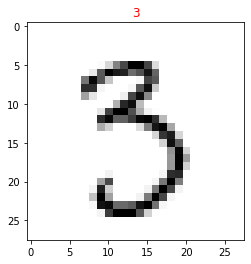

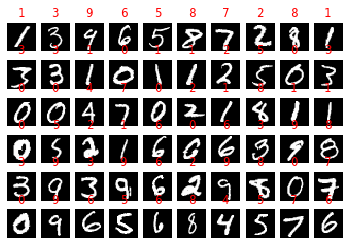

In [ ]:
#View Images
%matplotlib inline
import matplotlib.pyplot as plt
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print('Image : ',example_data.shape)
print('Target : ',example_targets.shape)
plt.imshow(example_data[1][0], cmap='gray_r')
plt.title("{}".format(example_targets[1]),color='red')

fig = plt.figure()
for i in range(60):
  plt.subplot(6,10,i+1)
  #plt.tight_layout()
  plt.imshow(example_data[i][0].numpy().squeeze(), cmap='gray', interpolation='none')
  plt.title("{}".format(example_targets[i]),color='red')
  plt.axis('off')


#Architecture

In [ ]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()

      #Input Block 1
      self.Conv1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(10)
      ) # ouput - 26

      # Convolution Block 1
      self.Conv2 = nn.Sequential(
          nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16)
      ) # ouput - 24

      # Transistion Block 1
      self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
      self.Conv3 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(10)
      ) # ouput - 12

      # Convolution Block 2

      self.Conv4 = nn.Sequential(
          nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16)
      ) # ouput - 10

      # Convolution Block 3

      self.Conv5 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16)
      ) # ouput - 8

      # Convolution Block 4

      self.Conv6 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16)
      ) # ouput - 6

      # Convolution Block 5

      self.GAP = nn.Sequential(
          nn.AvgPool2d(kernel_size=6)
      ) # ouput - 1

      # Convolution Block 6

      self.Conv7 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )
      
  def forward(self,x):
      x = self.Conv1(x)
      x = self.Conv2(x)
      x = self.pool1(x)
      x = self.Conv3(x)
      x = self.Conv4(x)
      x = self.Conv5(x)
      x = self.Conv6(x)
      x = self.GAP(x)
      x = self.Conv7(x) 

      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

#model Summary

In [ ]:
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,440
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 10, 12, 12]             160
              ReLU-9           [-1, 10, 12, 12]               0
      BatchNorm2d-10           [-1, 10, 12, 12]              20
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
           Conv2d-14             [

#Training

In [ ]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    loss.backward()
    optimizer.step()

    processed+=len(data)

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct+=pred.eq(target.data.view_as(pred)).sum().item()
    
    pbar.set_description('Train: Batch id: {} \tLoss: {:.6f}\t Accuracy:{:.3f}'.format(
        batch_idx, loss.item(),100*correct/processed))
    
    train_losses.append(loss.item())
    train_acc.append(100*correct/processed)

      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test(model, device, test_loader):
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: loss: {:.6f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  test_acc.append(100. * correct / len(test_loader.dataset))


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Train: Batch id: 937 	Loss: 0.026212	 Accuracy:92.755: 100%|██████████| 938/938 [00:21<00:00, 43.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.065776, Accuracy: 9818/10000 (98.180%)

EPOCH: 1


Train: Batch id: 937 	Loss: 0.057725	 Accuracy:98.463: 100%|██████████| 938/938 [00:21<00:00, 43.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.040987, Accuracy: 9871/10000 (98.710%)

EPOCH: 2


Train: Batch id: 937 	Loss: 0.027270	 Accuracy:98.805: 100%|██████████| 938/938 [00:21<00:00, 43.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.030227, Accuracy: 9907/10000 (99.070%)

EPOCH: 3


Train: Batch id: 937 	Loss: 0.017374	 Accuracy:99.015: 100%|██████████| 938/938 [00:21<00:00, 42.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.030698, Accuracy: 9910/10000 (99.100%)

EPOCH: 4


Train: Batch id: 937 	Loss: 0.019861	 Accuracy:99.103: 100%|██████████| 938/938 [00:21<00:00, 44.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.030367, Accuracy: 9908/10000 (99.080%)

EPOCH: 5


Train: Batch id: 937 	Loss: 0.002648	 Accuracy:99.172: 100%|██████████| 938/938 [00:21<00:00, 44.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.026195, Accuracy: 9915/10000 (99.150%)

EPOCH: 6


Train: Batch id: 937 	Loss: 0.003536	 Accuracy:99.238: 100%|██████████| 938/938 [00:20<00:00, 44.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.025190, Accuracy: 9922/10000 (99.220%)

EPOCH: 7


Train: Batch id: 937 	Loss: 0.018868	 Accuracy:99.338: 100%|██████████| 938/938 [00:21<00:00, 44.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.025834, Accuracy: 9923/10000 (99.230%)

EPOCH: 8


Train: Batch id: 937 	Loss: 0.024973	 Accuracy:99.288: 100%|██████████| 938/938 [00:21<00:00, 44.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.021455, Accuracy: 9931/10000 (99.310%)

EPOCH: 9


Train: Batch id: 937 	Loss: 0.006268	 Accuracy:99.433: 100%|██████████| 938/938 [00:21<00:00, 43.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.019730, Accuracy: 9941/10000 (99.410%)

EPOCH: 10


Train: Batch id: 937 	Loss: 0.004781	 Accuracy:99.583: 100%|██████████| 938/938 [00:21<00:00, 43.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.018960, Accuracy: 9946/10000 (99.460%)

EPOCH: 11


Train: Batch id: 937 	Loss: 0.007538	 Accuracy:99.602: 100%|██████████| 938/938 [00:21<00:00, 43.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.019786, Accuracy: 9943/10000 (99.430%)

EPOCH: 12


Train: Batch id: 937 	Loss: 0.007460	 Accuracy:99.645: 100%|██████████| 938/938 [00:20<00:00, 44.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.018657, Accuracy: 9945/10000 (99.450%)

EPOCH: 13


Train: Batch id: 937 	Loss: 0.002930	 Accuracy:99.653: 100%|██████████| 938/938 [00:21<00:00, 44.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: loss: 0.018760, Accuracy: 9943/10000 (99.430%)

EPOCH: 14


Train: Batch id: 937 	Loss: 0.011568	 Accuracy:99.653: 100%|██████████| 938/938 [00:21<00:00, 44.14it/s]



Test set: loss: 0.019344, Accuracy: 9944/10000 (99.440%)



Text(0.5, 1.0, 'Test Accuracy')

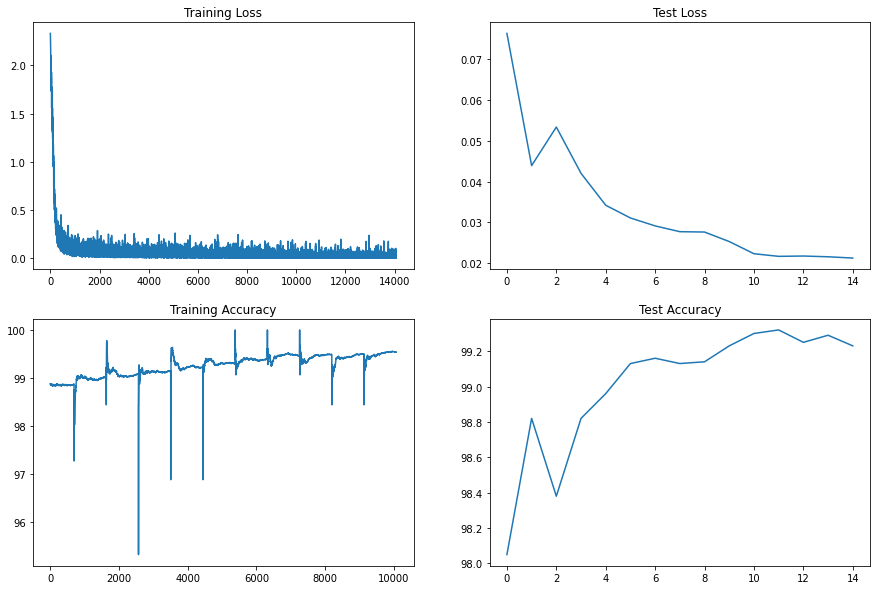

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")